### Final Project on Walmart Sales


####  For the project, I used Walmart's Sales Data from Kaggle (Data Source: https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting) and focused on attributes from train.csv and features.csv to address the following three questions:
1. Does external temperature affect Sales at Walmart?
2. Using the sample at hand, can we say that overall sales at Walmart have changed over the years - 2010, 2011, and 2012?
3. Can we segment all weeks in a year into distinct groups based on their aggregate sales?  This information can be used to design similar promotional campaigns within each segment.

#### Importing Packages 

In [166]:
#Importing packages
import pandas as pd
from pandasql import sqldf
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
from pandas.tools import plotting
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [167]:
# Importing project csv files and converting them into dataframes
train_data = pd.read_csv("/Users/mugdhapotdar/Downloads/train.csv")
features_data = pd.read_csv("/Users/mugdhapotdar/Downloads/features.csv")


In [168]:
# Checking data in the dataframes
train_data.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True


In [169]:
# Checking datatypes
train_data.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [170]:
# Checking data in the dataframes
features_data.head(2)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,33,2/5/10,58.40,2.962,NaN,NaN,NaN,NaN,NaN,126.442065,10.115,False
1,10,2/5/10,54.34,2.962,NaN,NaN,NaN,NaN,NaN,126.442065,9.765,False


In [171]:
# Checking datatypes
features_data.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
dtype: object

#### Feature Engineering

In [172]:
# Some of the fields do not appear to have the correct data type.
# 1. Converting Date column to dtype datetime
# 2. Converting dept and stores to dtype category
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Dept'] = train_data['Dept'].astype('int').astype('category')
train_data['Store'] = train_data['Store'].astype('int').astype('category')
train_data.dtypes

Store                 category
Dept                  category
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

In [173]:
# 1. Converting Date column to datetime 
# 2. Converting store to dtype category
features_data['Date'] = pd.to_datetime(features_data['Date'])  
features_data['Store'] = features_data['Store'].astype('int').astype('category')
features_data.dtypes

Store                 category
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
dtype: object

In [174]:
#Checking if Weekly_Sales has any NA value. If Yes, I will make an estimation of the sales value, if no then I will
#simply add Weekly_Sales per department to get total Weekly_Sales per store 
train_data['Weekly_Sales'].isnull().sum()

0

#### SQLDF Function to run SQL queries on DataFrames
Pandasql package allows to run SQL queries on DataFrames. 
Its main function "Sqldf" takes two parameters: SQL query and environment variable. 
Setting second variable as global    

In [175]:
#Inner join features_data with train_data on multiple keys
wmt_store_sales = py_sql("SELECT                                                            \
                                 fd.Store, fd.Date, fd.Temperature, fd.Fuel_Price, td.Sales \
                          FROM                                                              \
                                 (select                                                    \
                                        Store, Date, sum(Weekly_Sales) as Sales             \
                                  from                                                      \
                                      train_data                                            \
                                  group by                                                  \
                                      Store, Date) td                                       \
                          INNER JOIN                                                        \
                                    features_data fd                                        \
                          ON                                                                \
                                    td.Store = fd.Store                                     \
                          AND                                                               \
                                    td.Date = fd.Date;")

In [176]:
#Counting number of records in total_wmt_store_sales
wmt_store_sales.count()

Store          6435
Date           6435
Temperature    6435
Fuel_Price     6435
Sales          6435
dtype: int64

### Analysis for Objective 1
#### Does external temperature affect Sales at Walmart?
Here, I analyzed relationship between Sales and Temperature and plotted a regression line to see if there is any pattern. Viewing the scatterplot one can infer that data is all over the place, meaning there is no significant relationship between Sales and Temperature. However, the slope has a downward trend meaning as the temperature decreases, the Sales increase. One possible reasoning behind this is due to high number of outliers (Sales happening during winter - Thanksgiving and Christmas) which are causing the initial upward slope. Hence, I removed the outliers and re-analyzed the relationship. As seen in the second graph, the slope has reduced by 200% and the regression line is pretty flat leading to the conclusion that Temperature does not impact Sales at Store Level. 
#### Anomalies 
In order to obtain a robust analysis, I removed the outliers by considering the data within Median +/- 2 Standard Deviation as the data is not normally distributed hence taking median is a more accurate measure of central tendency than mean.

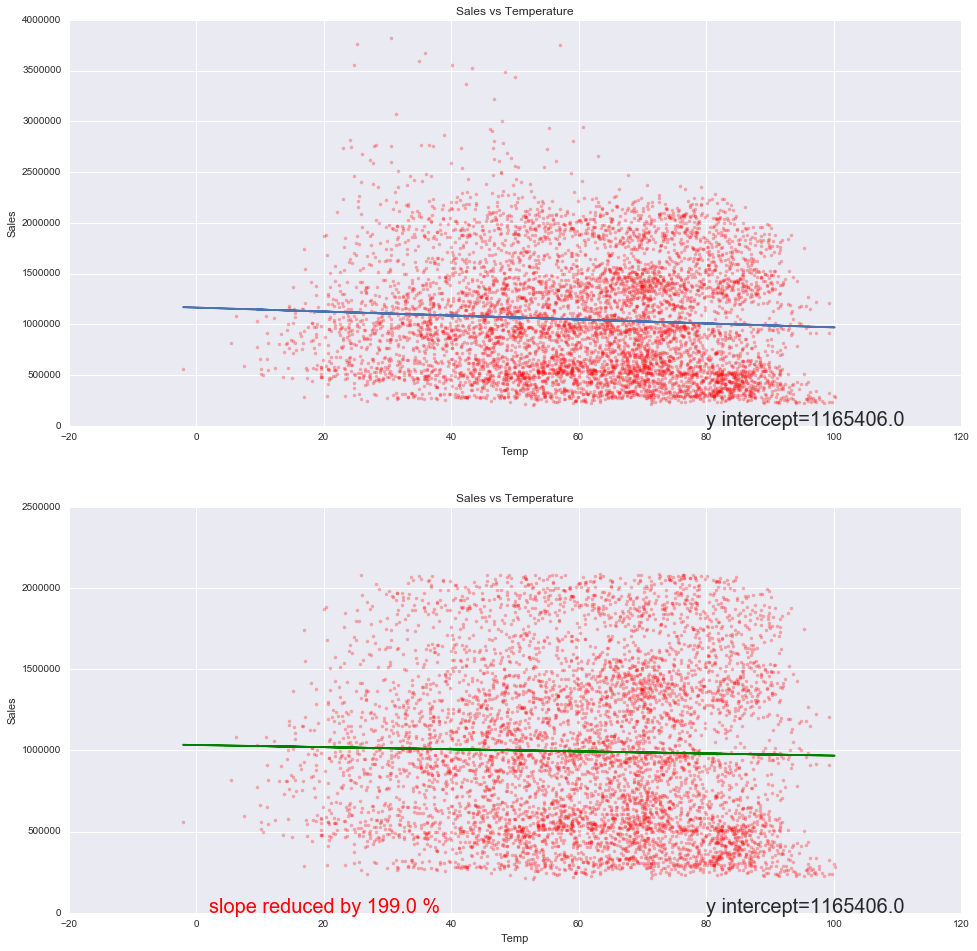

In [177]:
new_df = wmt_store_sales
# Remove outliers i.e. remove all datapoints outside median +/-2 standard deviations in the column Sales

new_df = new_df[np.abs(wmt_store_sales['Sales'] - wmt_store_sales['Sales'].median()) <= (2 * wmt_store_sales['Sales'].std())] 

new_df.count()

x = wmt_store_sales['Temperature']
y = wmt_store_sales['Sales']
x1 = new_df['Temperature']
y1 = new_df['Sales']

fig=plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='r')

plt.subplot(2, 1, 1) 
m, b = np.polyfit(x, y, 1)
plt.title('Sales vs Temperature') 
plt.ylabel('Sales')
plt.xlabel('Temp')
plt.plot(x , y , '.',alpha = 0.3,color='red')
plt.plot(x, m*x + b, '-')
#plt.text(2, 30, r'slope of fig1 is ='+ str((m)/(m1))+ ' times slope of fig2', fontsize=15)
plt.text(80, 700, r'y intercept=' + str(round(b)), fontsize=20)

plt.subplot(2, 1, 2) 
m1, b1 = np.polyfit(x1, y1, 1)
plt.title('Sales vs Temperature') 
plt.ylabel('Sales')
plt.xlabel('Temp')
plt.plot(x1 , y1 , '.',alpha = 0.3,color='red')
#plt.plot(x, m*x + b, '-')
plt.plot(x1, m1*x1 + b1, '-',color = 'green')

plt.text(2, 30, r'slope reduced by '+ str(round(((m - m1)*100/m1),0)) + ' %', fontsize=20,color = "red")
plt.text(80, 700, r'y intercept=' + str(round((b),0)), fontsize=20)
plt.show()



#### Takeaway 1:  Temperature doesn't impact Walmart sales. 
This is also supported by running Linear Regression Model. The value is R squared is very weak 0.04%

In [178]:

stats_model = ols('Sales ~  Temperature ', wmt_store_sales).fit()
print(stats_model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     26.30
Date:                Sat, 10 Sep 2016   Prob (F-statistic):           3.01e-07
Time:                        23:44:19   Log-Likelihood:                -94339.
No. Observations:                6435   AIC:                         1.887e+05
Df Residuals:                    6433   BIC:                         1.887e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    1.165e+06   2.41e+04     48.279      

### Further Analysis on Takeaway 1
Although temperature doesn't impact Walmart Sales at a store level, I wanted to analyze Impact of Temperature vs Sales by Department. This is because demand of certain products may go up depending on seasons.  For e.g. during summer, people have more pool parties, barbecue or buy beach accessories. Such seasonal demand can lead to an increase of departmental sales of these goods. Hence, I analyzed this relationship and observed two unique patterns:

1) Most of the departments fall into first pattern, where there is no relationship between temperature and sales. 

2) Interestingly, the second category represents departments such as 1, 7, 72, etc. where Sales go up when temperature is between 70 and 80 F. 

Key business insight: Inventory for the departments 1, 7, and 72 can be stocked up to meet the increase in demand during summer!

In [179]:
features_data1 = features_data
train_data1 = train_data

In [180]:
train_data1['Date'] = pd.to_datetime(train_data1['Date'])
features_data1['Date'] = pd.to_datetime(features_data1['Date'])  

In [181]:
train_data1.dtypes

Store                 category
Dept                  category
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

In [182]:
train_data1.count()

Store           421570
Dept            421570
Date            421570
Weekly_Sales    421570
IsHoliday       421570
dtype: int64

In [183]:
# # SQL
# # Inner join features_data with train_data on multiple keys
wmt_dept_sales = py_sql("SELECT fd.Store as Store, fd.Date as Date , fd.Temperature as Temperature,\
                                fd.Fuel_Price as Fuel_Price, td.Sales as Sales, td.Dept as Dept \
                         FROM (select Store, Dept, Date, Weekly_Sales as Sales \
                               from train_data1) td \
                         INNER JOIN features_data1 fd \
                         ON td.Store = fd.Store \
                         AND td.Date = fd.Date;" )

In [184]:
wmt_dept_sales.count()

Store          421570
Date           421570
Temperature    421570
Fuel_Price     421570
Sales          421570
Dept           421570
dtype: int64

In [185]:
wmt_dept_sales.head(2)

,Store,Date,Temperature,Fuel_Price,Sales,Dept
0,1,2010-02-05 00:00:00,42.31,2.572,24924.50,1
1,1,2010-02-12 00:00:00,38.51,2.548,46039.49,1


In [186]:
wmt_dept_sales = wmt_dept_sales.fillna(0)

In [187]:
wmt_dept_sales.count()

Store          421570
Date           421570
Temperature    421570
Fuel_Price     421570
Sales          421570
Dept           421570
dtype: int64

In [188]:
wmt_dept_sales.isnull().any()

Store          False
Date           False
Temperature    False
Fuel_Price     False
Sales          False
Dept           False
dtype: bool

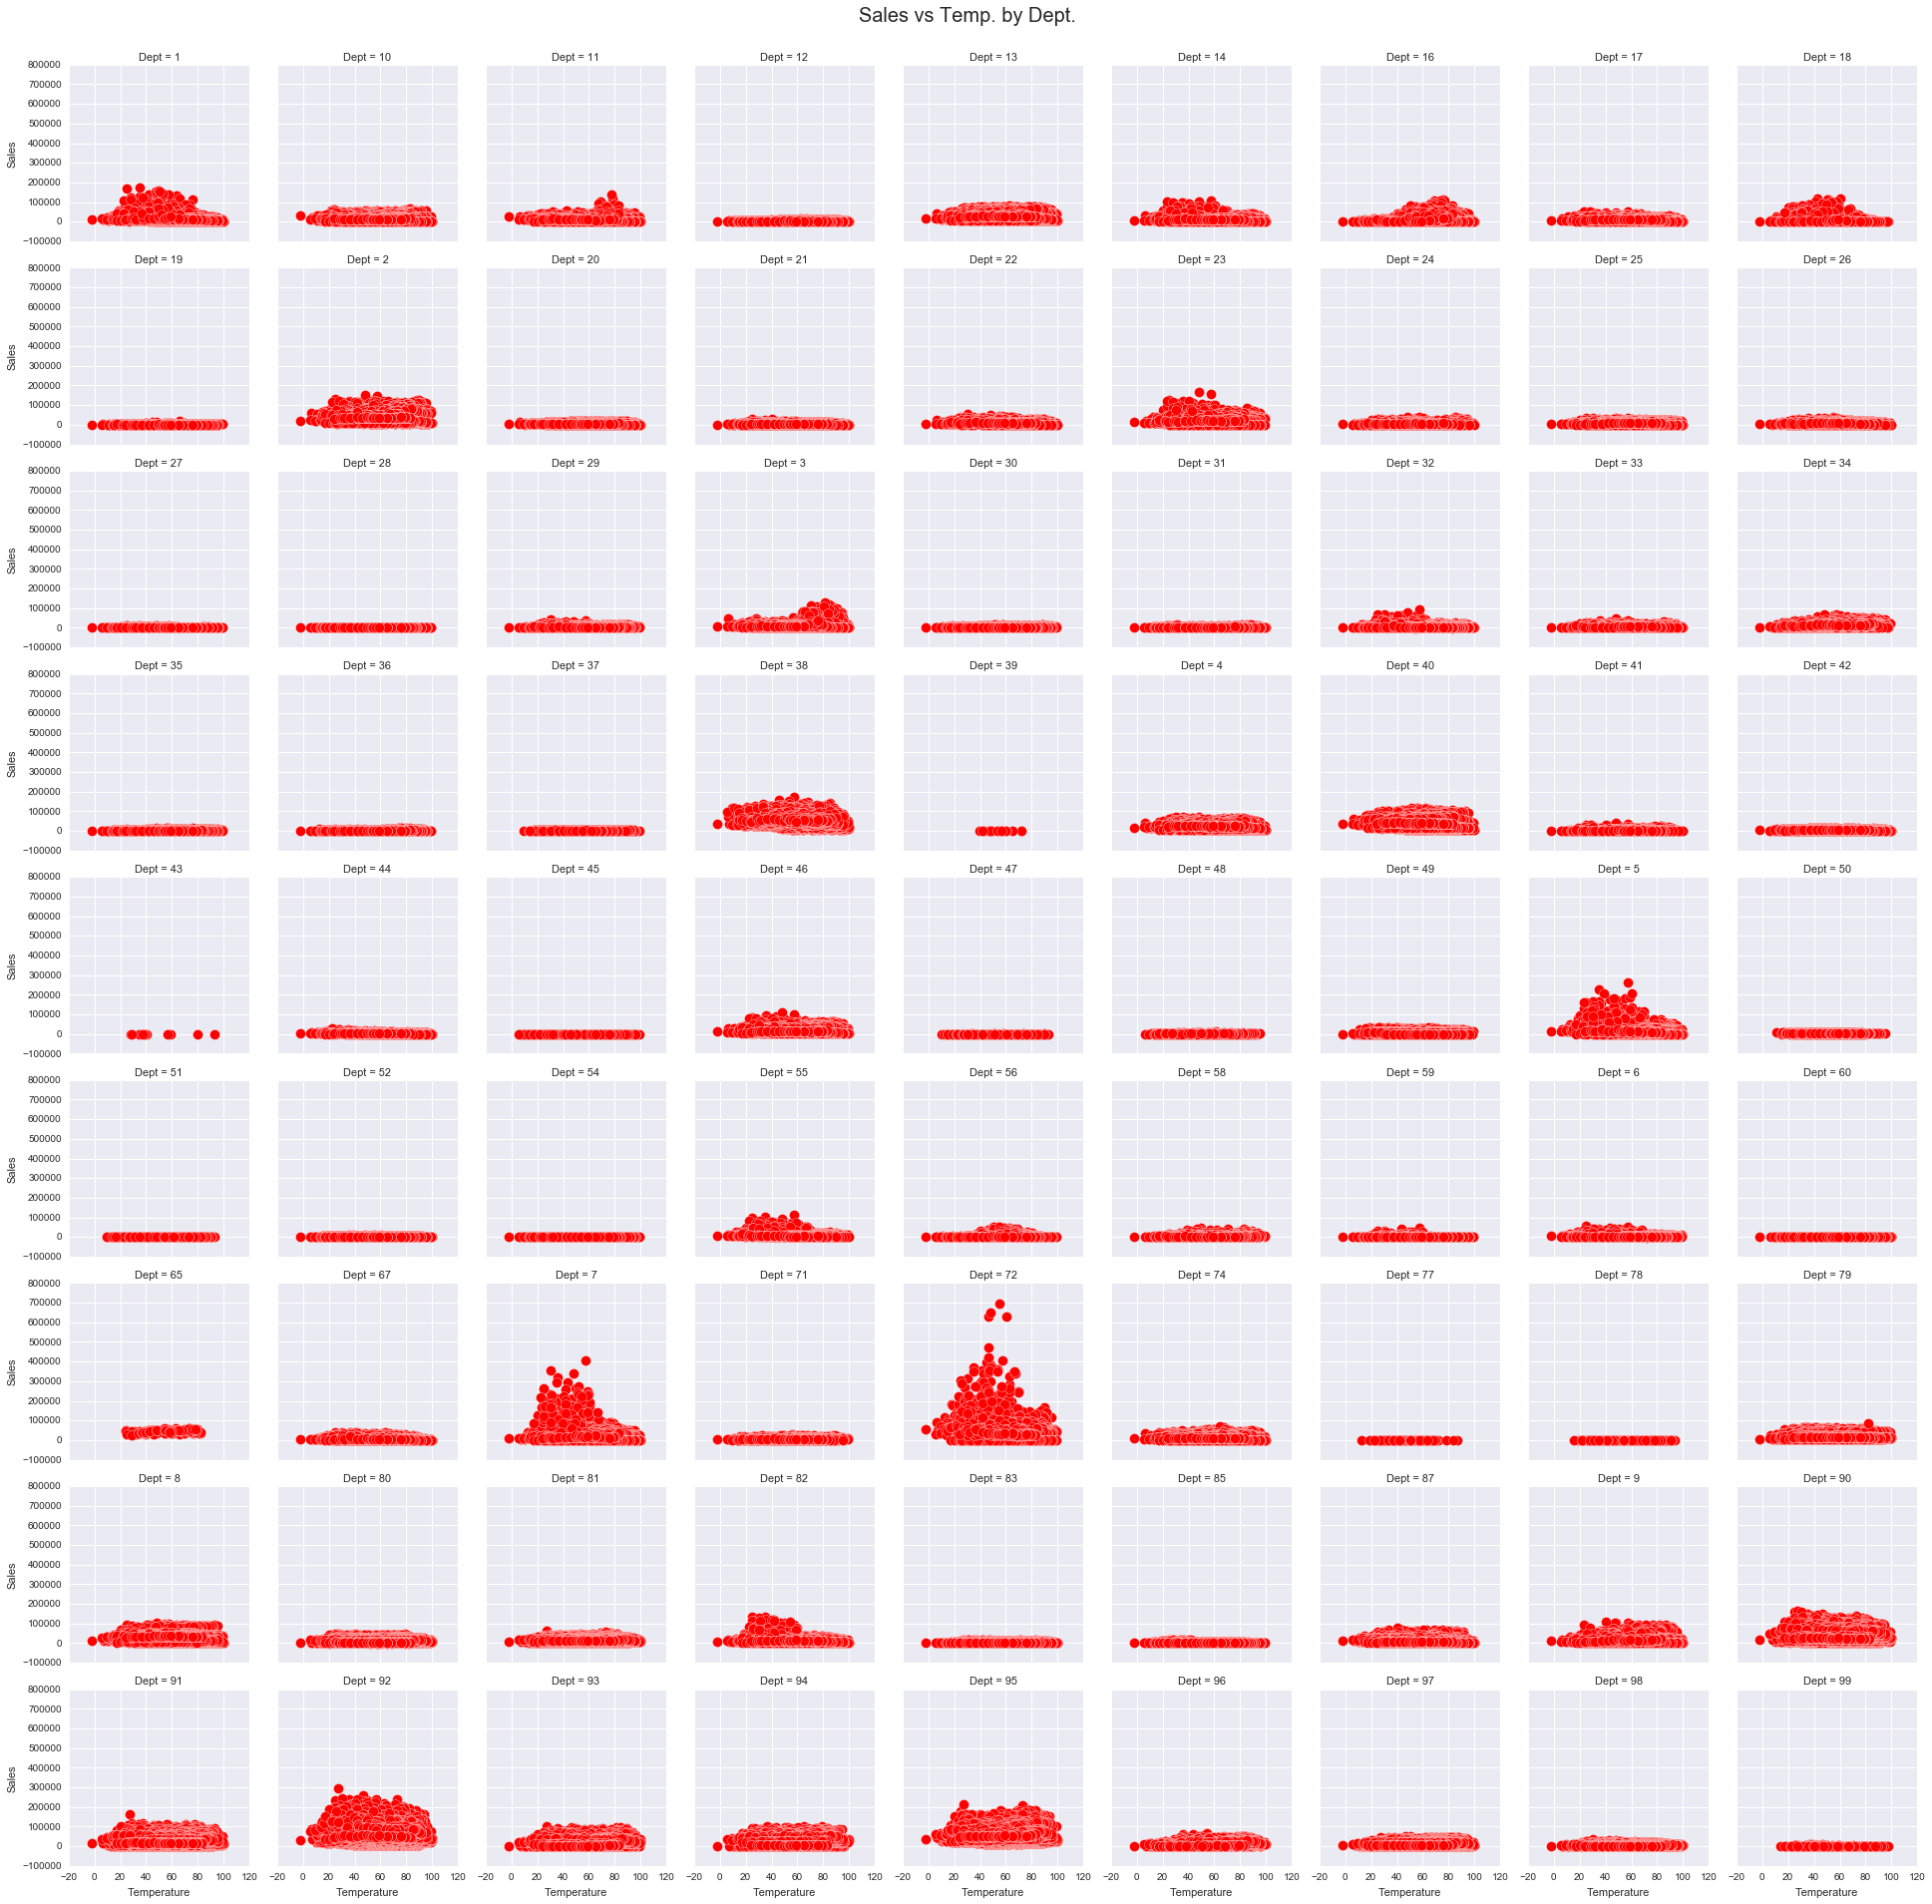

In [190]:
# Temp vs Sales by Dept
g = sns.FacetGrid(wmt_dept_sales, col="Dept", col_wrap = 9)
g = g.map(plt.scatter, "Temperature", "Sales", s = 100, color="red",edgecolor = "w")
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Sales vs Temp. by Dept.',fontsize = 20) 

### Analysis for Objective 2 
#### Using the sample at hand, can we say that overall sales at Walmart have changed over the years - 2010, 2011, and 2012?

Based on the random test data, I wanted to analyze if Walmart's U.S. Sales have changed over the past three years.  I first plotted the Density Distributions of the Sales data for three years and found that all three distributions were very gaussian looking.  Furthermore, the means for years 2010 and 2011 were almost identical but 2012 had a slightly higher mean.  I now wanted to test if this difference was statistically significant.
So I went ahead and created a statistical test to test the hypothesis that year 2012 has statistically different sales than year 2010.

Objective: Do we have enough statistical evidence to prove that the Walmart's U.S. sales in 2012 (entire population)  has changed in 2012 compared to 2010?

As the density distribution of three samples are Gaussian style, I ran an ANOVA test. One way of running ANOVA is by running a linear regression model between categorical predictor variables and numeric output variable. My predictor variables are 2010, 2011 and 2012 and output variable is Sales.

In [191]:
wmt_store_sales.count()

Store          6435
Date           6435
Temperature    6435
Fuel_Price     6435
Sales          6435
dtype: int64

In [192]:
#Extracting Year and Week from the Date column and as I am using Week number and Year number for analysis
wmt_store_sales['Year'] = pd.DatetimeIndex(wmt_store_sales['Date']).year
wmt_store_sales['Week'] = pd.DatetimeIndex(wmt_store_sales['Date']).week

In [193]:
data.count()

Sales    6435
Week     6435
Year     6435
dtype: int64

In [194]:
data = wmt_store_sales[['Sales','Week','Year']]

In [195]:
# # SQL
# # Inner join features_data with train_data on multiple keys
data_df = py_sql("SELECT Temp1.*                          \
                  FROM                                    \
                  (                                       \
                  SELECT sum(Sales) as Sales, Week, Year  \
                  FROM data                               \
                  group by Week, Year                     \
                  Order by Week, Year                     \
                  ) Temp1 ,                               \
                  (                                       \
                  SELECT Week, count(*) cnt               \
                  FROM                                    \
                  (                                       \
                  SELECT sum(Sales) as Sales, Week, Year  \
                  FROM data                               \
                  group by Week, Year                     \
                  Order by Week, Year                     \
                  ) group by Week having count(*) = 3     \
                  ) Temp2                                 \
                  WHERE Temp1.Week = Temp2.Week           \
                 ;")

In [196]:
data_df.head(2)

,Sales,Week,Year
0,49750740.50,5,2010
1,46153111.12,5,2011


In [197]:
# Creating three dataframes to store Sales data by year
data1 = data_df[data_df.Year == 2010]

In [198]:
data1.count()

Sales    39
Week     39
Year     39
dtype: int64

In [199]:
data2 = data_df[data_df.Year == 2011]

In [200]:
data2.count()

Sales    39
Week     39
Year     39
dtype: int64

In [201]:
data3 = data_df[data_df.Year == 2012]

In [202]:
data3.count()

Sales    39
Week     39
Year     39
dtype: int64

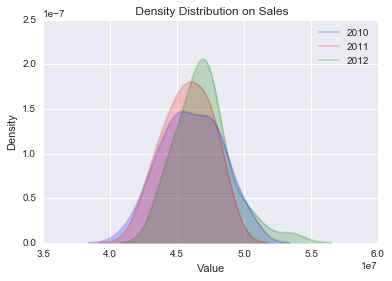

In [203]:
import plotly.plotly as py

sns.kdeplot(data1['Sales'], shade = True, bw=1000000, label = '2010', color = 'blue',alpha = 0.2)
sns.kdeplot(data2['Sales'], shade = True, bw=1000000, label = '2011', color = 'red', alpha = 0.2)
sns.kdeplot(data3['Sales'], shade = True, bw=1000000, label = '2012', color = 'green', alpha = 0.2)

plt.title(" Density Distribution on Sales")
plt.xlabel("Value")
plt.ylabel("Density")

fig = plt.gcf()

In [204]:
data_df.count()

Sales    117
Week     117
Year     117
dtype: int64

In [205]:
anova_lm_model = ols('Sales ~  C(Year)', data_df).fit()
print(anova_lm_model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     3.445
Date:                Sat, 10 Sep 2016   Prob (F-statistic):             0.0353
Time:                        23:44:51   Log-Likelihood:                -1863.3
No. Observations:                 117   AIC:                             3733.
Df Residuals:                     114   BIC:                             3741.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        4.608e+07   3.24e+05    1

#### Result: 
Based on the ANOVA Regression Model, with a p value of 0.06 for Year 2012, we can say with 94% confidence that  Walmart's U.S. Sales for 2012 differs from 2010.

#### Takeaway 2: We have enough statistical evidence ( 94% confidence level ) to prove that Walmart's U.S. Sales for 2012 is different from 2010 . 



### Analysis for Objective 3 
#### Can we segment all weeks in a year into distinct groups based on their aggregate sales? This information can be used to design similar promotional campaigns within each segment.
Here, I performed KMeans Clustering on most recent Year dataset (2012) on one dimension i.e. Sales and created three clusters for Low, Medium and High Sales. 

For previous analyses, I have used 39 weeks data for Year 1, 2 and 3. Hence, I have again used same number of weeks in this analysis to retain consistency.

In [206]:
data3.count()

Sales    39
Week     39
Year     39
dtype: int64

(array([ 23.,  11.,   5.]),
 array([ 0.        ,  0.66666667,  1.33333333,  2.        ]),
 <a list of 3 Patch objects>)

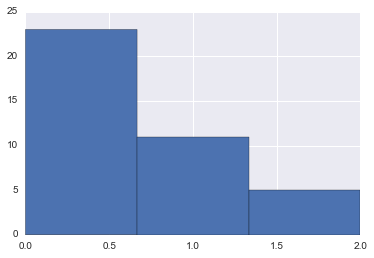

In [207]:
# Used Dataset for Year 2012 to perform K Means Clustering
import numpy as np
from sklearn.cluster import KMeans

x = data3['Sales']
km = KMeans(n_clusters = 3)
km.fit(x.reshape(-1,1))
my_kmeans_prediction = km.predict(x.reshape(-1,1))
plt.hist(my_kmeans_prediction, bins = 3)

In [208]:
# Values 0,1 and 2 represent three segments 
my_kmeans_prediction

array([0, 2, 2, 1, 0, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1], dtype=int32)

#### Result 

1. Low Walmart Sales occur for few weeks (11 weeks)
2. Average Walmart Sales occur for Maximum number of weeks (23 weeks)
3. Highest Walmart Sales occur for very few weeks (5 weeks)

### Conclusion
#### Takeaway 1:  Temperature doesn't impact Walmart sales at Store level. However, it does impact Sales at Department Level for certain stores.  
Business Insight: Stock up Inventory for the departments which show seasonal sales impact and capture additional market share by meeting the Sales Demand

#### Takeaway 2 :  We have enough statistical evidence (94% confidence level ) to prove that Walmart's U.S. Sales for 2012 is different from 2010 . 

Business Insight: Walmart's U.S. Sales have improved in 2012 compared to the previous years. 

#### Takeaway 3 :  Sales Data for each year can be grouped into three segments: Low, Medium and High Sales using KMeans Clustering
Business Insight: Marketing Department can run marketing campaigns of similar value for all weeks in a particular segment. 

